In [1]:
from pathlib import Path

dataset_path = Path(r'/home/thor/Desktop/datasets/emoji-hero/')

training_set_path = dataset_path / 'training_set'
validation_set_path = dataset_path / 'validation_set'
test_set_path = dataset_path / 'test_set'

id_to_emotion = {
    0: 'Neutral',
    1: 'Happy',
    2: 'Sad',
    3: 'Surprise',
    4: 'Fear',
    5: 'Disgust',
    6: 'Anger',
}


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SEED = 42

In [3]:
def compute_class_frequencies(dataset_path: Path) -> dict:
    class_frequencies = {}
    for class_dir in sorted(dataset_path.iterdir()):
        num_files = sum(1 for _ in class_dir.iterdir())
        class_id = int(class_dir.name)
        class_frequencies[class_id] = num_files
        print(f'{class_id} - {id_to_emotion[class_id]:<9} : {num_files:>8} images')

    return class_frequencies


In [4]:
import keras

print('---TRAINING SET---')
training_set = keras.preprocessing.image_dataset_from_directory(training_set_path,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=True,
                                                                seed=SEED)

class_frequencies = compute_class_frequencies(training_set_path)


2024-03-20 15:25:59.877721: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 15:26:00.003845: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 15:26:00.003894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 15:26:00.023641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 15:26:00.064018: I tensorflow/core/platform/cpu_feature_guar

---TRAINING SET---
Found 2030 files belonging to 7 classes.


2024-03-20 15:26:01.302249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 15:26:01.373232: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 15:26:01.373357: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

0 - Neutral   :      414 images
1 - Happy     :      400 images
2 - Sad       :      274 images
3 - Surprise  :      360 images
4 - Fear      :      220 images
5 - Disgust   :      212 images
6 - Anger     :      150 images


In [5]:
print('---VALIDATION SET---')
validation_set = keras.preprocessing.image_dataset_from_directory(validation_set_path,
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMAGE_SIZE,
                                                                  shuffle=True,
                                                                  seed=SEED)

compute_class_frequencies(validation_set_path)


---VALIDATION SET---
Found 770 files belonging to 7 classes.
0 - Neutral   :      110 images
1 - Happy     :      110 images
2 - Sad       :      110 images
3 - Surprise  :      110 images
4 - Fear      :      110 images
5 - Disgust   :      110 images
6 - Anger     :      110 images


{0: 110, 1: 110, 2: 110, 3: 110, 4: 110, 5: 110, 6: 110}

In [6]:
total_num_samples = sum(class_frequencies.values())
inverse_class_frequencies = {class_id: 1 / (frequency / total_num_samples) for class_id, frequency in
                             class_frequencies.items()}

total_inverse_class_frequencies = sum(inverse_class_frequencies.values())
class_weights = {class_id: freq / total_inverse_class_frequencies for class_id, freq in
                 inverse_class_frequencies.items()}

print(class_weights)


{0: 0.08856927366991273, 1: 0.09166919824835967, 2: 0.13382364707789735, 3: 0.10185466472039963, 4: 0.1666712695424721, 5: 0.1729607514119994, 6: 0.2444511953289591}


In [7]:
from keras import layers
from keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip(mode="horizontal"),
    layers.RandomTranslation(height_factor=0.05, width_factor=0.05, fill_mode="constant"),
    layers.RandomRotation(0.1, fill_mode="constant"),
    layers.RandomZoom(0.1, fill_mode="constant"),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1)
])

inputs = layers.Input(shape=(*IMAGE_SIZE, 3))
x = data_augmentation(inputs)


In [8]:
from keras.src.applications import EfficientNetB0


def build_model(num_classes, inputs_layer):
    model = EfficientNetB0(include_top=False, input_tensor=inputs_layer, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.2, name="top_dropout1")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    return keras.Model(inputs, outputs, name="EfficientNet")


model = build_model(len(class_frequencies), x)
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['sequential[0][0]']          
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                   

In [9]:
num_layers = len(model.layers)
for i, layer in enumerate(model.layers):
    print((num_layers - i), layer.name, layer.__class__.__name__)

242 input_1 InputLayer
241 sequential Sequential
240 rescaling Rescaling
239 normalization Normalization
238 rescaling_1 Rescaling
237 stem_conv_pad ZeroPadding2D
236 stem_conv Conv2D
235 stem_bn BatchNormalization
234 stem_activation Activation
233 block1a_dwconv DepthwiseConv2D
232 block1a_bn BatchNormalization
231 block1a_activation Activation
230 block1a_se_squeeze GlobalAveragePooling2D
229 block1a_se_reshape Reshape
228 block1a_se_reduce Conv2D
227 block1a_se_expand Conv2D
226 block1a_se_excite Multiply
225 block1a_project_conv Conv2D
224 block1a_project_bn BatchNormalization
223 block2a_expand_conv Conv2D
222 block2a_expand_bn BatchNormalization
221 block2a_expand_activation Activation
220 block2a_dwconv_pad ZeroPadding2D
219 block2a_dwconv DepthwiseConv2D
218 block2a_bn BatchNormalization
217 block2a_activation Activation
216 block2a_se_squeeze GlobalAveragePooling2D
215 block2a_se_reshape Reshape
214 block2a_se_reduce Conv2D
213 block2a_se_expand Conv2D
212 block2a_se_excite M

In [10]:
def unfreeze_model(model, num_layers):
    for layer in model.layers[-num_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

In [11]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
checkpoint_dir = Path(f"emojihero_transfer_imagenet_{timestamp}")
training_histories = []
epoch_counter = 0
epochs_per_phase = [20, 20, 20, 20, 40, 10]
layers_to_unfreeze_per_phase = [3, 19, 78, 194, len(model.layers), len(model.layers)]
learning_rate_per_phase = [1e-3, 1e-3, 1e-3, 1e-4, 1e-5, 1e-6]

for phase, (epochs, layers_to_unfreeze, learning_rate) in enumerate(
        zip(epochs_per_phase, layers_to_unfreeze_per_phase, learning_rate_per_phase)):

    print(f'\n---STARTING TRAINING PHASE {phase}')
    print(f'EPOCHS:{epochs} LAYERS_TO_UNFREEZE:{layers_to_unfreeze} LEARNING_RATE:{learning_rate}')
    checkpoint_filepath = str(checkpoint_dir / f'best_model_phase_{phase}.keras')

    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                save_weights_only=False,
                                                monitor='val_accuracy',
                                                mode='max',
                                                save_best_only=True)

    if phase > 0:
        old_checkpoint_filepath = checkpoint_filepath.replace(f'phase_{phase}', f'phase_{phase - 1}')
        print(f'Loading model from {old_checkpoint_filepath}')
        model = load_model(old_checkpoint_filepath)
        
    unfreeze_model(model, layers_to_unfreeze)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    hist = model.fit(training_set,
                     epochs=epoch_counter + epochs,
                     validation_data=validation_set,
                     class_weight=class_weights,
                     callbacks=[model_checkpoint_callback],
                     initial_epoch=epoch_counter)

    epoch_counter += epochs
    training_histories.append(hist)


---STARTING TRAINING PHASE 0
EPOCHS:20 LAYERS_TO_UNFREEZE:3 LEARNING_RATE:0.001
Epoch 1/20


2024-03-20 15:26:08.662780: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-20 15:26:08.752705: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 3/64 [>.............................] - ETA: 2s - loss: 0.2342 - accuracy: 0.2188  

2024-03-20 15:26:09.332405: I external/local_xla/xla/service/service.cc:168] XLA service 0x77b40fe0d620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-20 15:26:09.332445: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-20 15:26:09.338601: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710944769.399856    5420 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 [==============================] - 9s 56ms/step - loss: 0.2455 - accuracy: 0.1946 - val_loss: 1.9009 - val_accuracy: 0.1818
Epoch 2/20
64/64 [==============================] - 3s 39ms/step - loss: 0.2287 - accuracy: 0.2729 - val_loss: 1.8342 - val_accuracy: 0.2442
Epoch 3/20
64/64 [==============================] - 3s 43ms/step - loss: 0.2176 - accuracy: 0.3241 - val_loss: 1.8023 - val_accuracy: 0.2532
Epoch 4/20
64/64 [==============================] - 3s 47ms/step - loss: 0.2092 - accuracy: 0.3852 - val_loss: 1.7465 - val_accuracy: 0.2753
Epoch 5/20
64/64 [==============================] - 3s 42ms/step - loss: 0.2014 - accuracy: 0.3980 - val_loss: 1.7349 - val_accuracy: 0.3078
Epoch 6/20
64/64 [==============================] - 3s 40ms/step - loss: 0.1978 - accuracy: 0.4355 - val_loss: 1.7005 - val_accuracy: 0.3247
Epoch 7/20
64/64 [==============================] - 3s 40ms/step - loss: 0.1933 - accuracy: 0.4473 - val_loss: 1.7042 - val_accuracy: 0.3260
Epoch 8/20
64/64 [======

2024-03-20 15:27:10.803852: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - 9s 58ms/step - loss: 0.1833 - accuracy: 0.4749 - val_loss: 1.4548 - val_accuracy: 0.4286
Epoch 22/40
64/64 [==============================] - 3s 41ms/step - loss: 0.1282 - accuracy: 0.6404 - val_loss: 1.5719 - val_accuracy: 0.4883
Epoch 23/40
64/64 [==============================] - 3s 49ms/step - loss: 0.1114 - accuracy: 0.6936 - val_loss: 1.3800 - val_accuracy: 0.5377
Epoch 24/40
64/64 [==============================] - 3s 42ms/step - loss: 0.0975 - accuracy: 0.7330 - val_loss: 1.4266 - val_accuracy: 0.5506
Epoch 25/40
64/64 [==============================] - 2s 37ms/step - loss: 0.0937 - accuracy: 0.7488 - val_loss: 1.6193 - val_accuracy: 0.5052
Epoch 26/40
64/64 [==============================] - 3s 39ms/step - loss: 0.0838 - accuracy: 0.7665 - val_loss: 2.2992 - val_accuracy: 0.4883
Epoch 27/40
64/64 [==============================] - 3s 42ms/step - loss: 0.0800 - accuracy: 0.7744 - val_loss: 1.7010 - val_accuracy: 0.5481
Epoch 28/40
64/64 

2024-03-20 15:29:18.678976: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - 16s 83ms/step - loss: 0.0235 - accuracy: 0.9394 - val_loss: 1.3735 - val_accuracy: 0.6714
Epoch 62/80
64/64 [==============================] - 4s 66ms/step - loss: 0.0191 - accuracy: 0.9483 - val_loss: 1.4317 - val_accuracy: 0.6597
Epoch 63/80
64/64 [==============================] - 4s 64ms/step - loss: 0.0151 - accuracy: 0.9542 - val_loss: 1.7843 - val_accuracy: 0.6338
Epoch 64/80
64/64 [==============================] - 4s 64ms/step - loss: 0.0141 - accuracy: 0.9631 - val_loss: 2.1182 - val_accuracy: 0.6312
Epoch 65/80
64/64 [==============================] - 4s 68ms/step - loss: 0.0146 - accuracy: 0.9611 - val_loss: 1.8105 - val_accuracy: 0.6442
Epoch 66/80
64/64 [==============================] - 4s 66ms/step - loss: 0.0140 - accuracy: 0.9650 - val_loss: 1.9529 - val_accuracy: 0.6234
Epoch 67/80
64/64 [==============================] - 4s 66ms/step - loss: 0.0132 - accuracy: 0.9675 - val_loss: 1.6713 - val_accuracy: 0.6558
Epoch 68/80
64/64

2024-03-20 15:31:02.723229: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - 20s 122ms/step - loss: 0.0058 - accuracy: 0.9872 - val_loss: 1.4964 - val_accuracy: 0.7026
Epoch 82/120
64/64 [==============================] - 6s 93ms/step - loss: 0.0047 - accuracy: 0.9901 - val_loss: 1.5873 - val_accuracy: 0.7026
Epoch 83/120
64/64 [==============================] - 6s 88ms/step - loss: 0.0031 - accuracy: 0.9936 - val_loss: 1.6934 - val_accuracy: 0.6948
Epoch 84/120
64/64 [==============================] - 6s 89ms/step - loss: 0.0052 - accuracy: 0.9872 - val_loss: 1.6124 - val_accuracy: 0.7026
Epoch 85/120
64/64 [==============================] - 6s 89ms/step - loss: 0.0032 - accuracy: 0.9936 - val_loss: 1.7247 - val_accuracy: 0.6961
Epoch 86/120
64/64 [==============================] - 6s 89ms/step - loss: 0.0039 - accuracy: 0.9926 - val_loss: 1.7734 - val_accuracy: 0.6909
Epoch 87/120
64/64 [==============================] - 6s 90ms/step - loss: 0.0034 - accuracy: 0.9926 - val_loss: 1.8246 - val_accuracy: 0.6922
Epoch 88/1

2024-03-20 15:35:10.858133: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - 19s 106ms/step - loss: 0.0044 - accuracy: 0.9906 - val_loss: 1.5235 - val_accuracy: 0.7026
Epoch 122/130
64/64 [==============================] - 6s 88ms/step - loss: 0.0048 - accuracy: 0.9887 - val_loss: 1.5355 - val_accuracy: 0.7026
Epoch 123/130
64/64 [==============================] - 6s 89ms/step - loss: 0.0053 - accuracy: 0.9901 - val_loss: 1.5372 - val_accuracy: 0.7026
Epoch 124/130
64/64 [==============================] - 6s 88ms/step - loss: 0.0051 - accuracy: 0.9887 - val_loss: 1.5450 - val_accuracy: 0.7026
Epoch 125/130
64/64 [==============================] - 6s 95ms/step - loss: 0.0043 - accuracy: 0.9897 - val_loss: 1.5555 - val_accuracy: 0.7039
Epoch 126/130
64/64 [==============================] - 6s 89ms/step - loss: 0.0033 - accuracy: 0.9926 - val_loss: 1.5653 - val_accuracy: 0.7013
Epoch 127/130
64/64 [==============================] - 6s 91ms/step - loss: 0.0042 - accuracy: 0.9897 - val_loss: 1.5799 - val_accuracy: 0.7026
Epoc

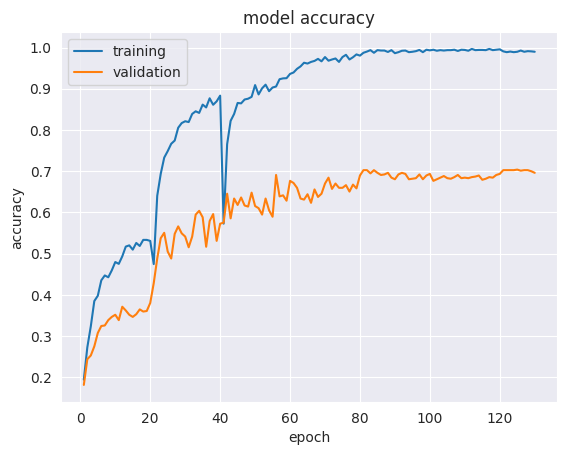

In [12]:
import matplotlib.pyplot as plt


def plot_and_save_combined_history(hists, checkpoint_dir):
    acc = []
    val_acc = []

    for hist in hists:
        acc += hist.history["accuracy"]
        val_acc += hist.history["val_accuracy"]

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label="training")
    plt.plot(epochs, val_acc, label="validation")
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")

    plt.savefig(str(checkpoint_dir / 'training_history.png'))

    plt.show()


plot_and_save_combined_history(training_histories, checkpoint_dir)

In [13]:
import csv


def save_training_history_csv(hists, checkpoint_dir):
    acc = []
    val_acc = []
    for hist in hists:
        acc.extend(hist.history["accuracy"])
        val_acc.extend(hist.history["val_accuracy"])

    epochs = range(1, len(acc) + 1)

    # CSV-Datei schreiben
    with (checkpoint_dir / 'training_history.csv').open(mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['epoch', 'accuracy', 'val_accuracy'])
        for epoch, accuracy, val_accuracy in zip(epochs, acc, val_acc):
            writer.writerow([epoch, accuracy, val_accuracy])


save_training_history_csv(training_histories, checkpoint_dir)

In [14]:
best_checkpoint = str(checkpoint_dir / "best_model_phase_5.keras")
model = load_model(best_checkpoint)

In [15]:
print('\n---TEST SET---')
test_set = keras.preprocessing.image_dataset_from_directory(test_set_path,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE,
                                                            shuffle=False)
compute_class_frequencies(test_set_path)



---TEST SET---
Found 756 files belonging to 7 classes.
0 - Neutral   :      108 images
1 - Happy     :      108 images
2 - Sad       :      108 images
3 - Surprise  :      108 images
4 - Fear      :      108 images
5 - Disgust   :      108 images
6 - Anger     :      108 images


{0: 108, 1: 108, 2: 108, 3: 108, 4: 108, 5: 108, 6: 108}

In [16]:
test_loss, test_acc = model.evaluate(test_set)
print(f"Test accuracy: {test_acc}")

24/24 [==============================] - 2s 30ms/step - loss: 1.5114 - accuracy: 0.6984
Test accuracy: 0.6984127163887024


In [17]:
import numpy as np
from sklearn.metrics import classification_report

y_pred_vectors = model.predict(test_set)
y_pred = np.argmax(y_pred_vectors, axis=1)
y_true = np.concatenate([y for _, y in test_set], axis=0)

report = classification_report(y_true, y_pred, target_names=id_to_emotion.values(), digits=4)
print(report)

24/24 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

     Neutral     0.7788    0.7500    0.7642       108
       Happy     0.6992    0.8611    0.7718       108
         Sad     0.8072    0.6204    0.7016       108
    Surprise     0.8911    0.8333    0.8612       108
        Fear     0.7816    0.6296    0.6974       108
     Disgust     0.5606    0.6852    0.6167       108
       Anger     0.4741    0.5093    0.4911       108

    accuracy                         0.6984       756
   macro avg     0.7133    0.6984    0.7006       756
weighted avg     0.7133    0.6984    0.7006       756


[[81  5  4  0  0  4 14]
 [ 3 93  0  0  1  3  8]
 [ 7  0 67  0  0  3 31]
 [ 1  0  1 90 14  1  1]
 [ 6  8  4  7 68 15  0]
 [ 2 19  2  2  2 74  7]
 [ 4  8  5  2  2 32 55]]


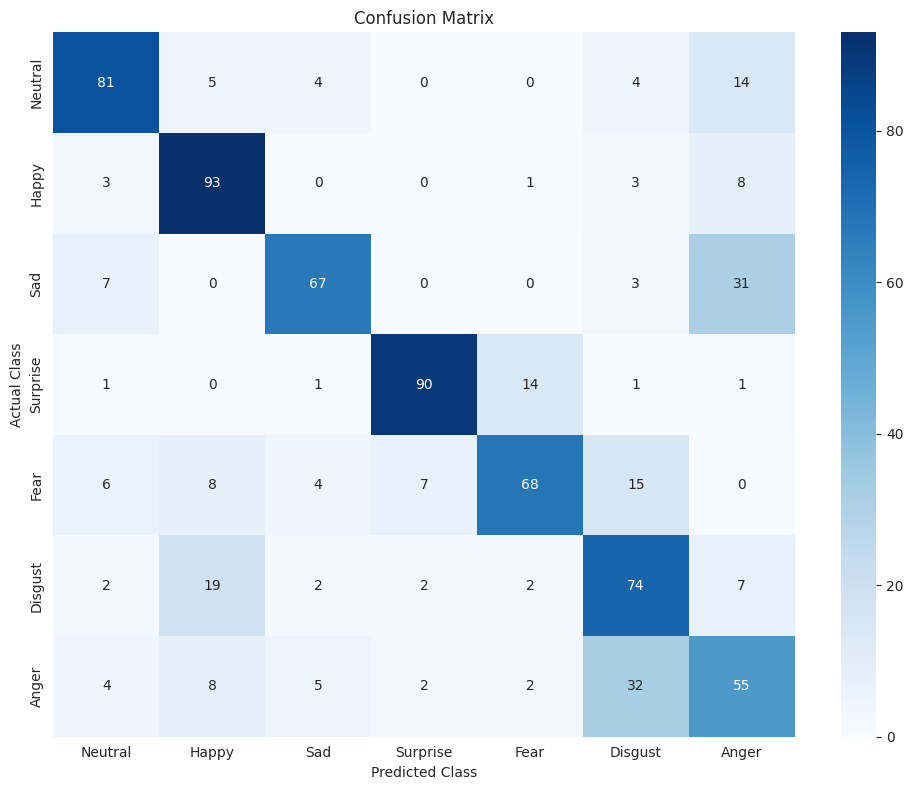

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    class_names = id_to_emotion.values()

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.tight_layout()
    plt.show()

    return fig


cm_figure = plot_confusion_matrix(y_true, y_pred)


In [19]:
def save_evaluation_results(report, cm_figure, checkpoint_dir):
    with (checkpoint_dir / 'classification_report.txt').open(mode='w') as f:
        f.write(report)
    cm_figure.savefig(str(checkpoint_dir / 'confusion_matrix.png'))


save_evaluation_results(report, cm_figure, checkpoint_dir)

In [20]:
import shutil

path_to_this_notebook = Path('/home/thor/Desktop/repos/emoji-hero-baseline/emojihero_transfer_imagenet.ipynb')

shutil.copy2(path_to_this_notebook, (checkpoint_dir / path_to_this_notebook.name))

PosixPath('emojihero_transfer_imagenet_20240320-1526/emojihero_transfer_imagenet.ipynb')